In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

if you aggregate
the predictions of a group of predictors (such as classifiers or regressors), you will
often get better predictions than with the best individual predictor. A group of pre‐
dictors is called an ensemble; thus, this technique is called Ensemble Learning, and an
Ensemble Learning algorithm is called an Ensemble method.

As an example of an Ensemble method, you can train a group of Decision Tree classi‐
fiers, each on a different random subset of the training set. To make predictions, you
obtain the predictions of all the individual trees, then predict the class that gets the
most votes (see the last exercise in Chapter 6). Such an ensemble of Decision Trees is
called a Random Forest, and despite its simplicity, this is one of the most powerful
Machine Learning algorithms available today.

As discussed in Chapter 2, you will often use Ensemble methods near the end of a
project, once you have already built a few good predictors, to combine them into an
even better predictor.

# Voting Classifiers

A very simple way to create an even better classifier is to aggregate the predictions of
each classifier and predict the class that gets the most votes. This majority-vote classi‐
fier is called a hard voting classifier

Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the
best classifier in the ensemble. In fact, even if each classifier is a weak learner (mean‐
ing it does only slightly better than random guessing), the ensemble can still be a
strong learner (achieving high accuracy), provided there are a sufficient number of
weak learners and they are sufficiently diverse.


The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


There you have it! The voting classifier slightly outperforms all the individual
classifiers

# Soft Voting 
If all classifiers are able to estimate class probabilities (i.e., they all have a pre
dict_proba() method), then you can tell Scikit-Learn to predict the class with the
highest class probability, averaged over all the individual classifiers. This is called soft
voting. It often achieves higher performance than hard voting because it gives more
weight to highly confident votes. All you need to do is replace voting="hard" with
voting="soft" and ensure that all classifiers can estimate class probabilities.

This is
not the case for the SVC class by default, so you need to set its probability hyper‐
parameter to True (this will make the SVC class use cross-validation to estimate class
probabilities, slowing down training, and it will add a predict_proba() method). If
you modify the preceding code to use soft voting, you will find that the voting classi‐
fier achieves over 91.2% accuracy!

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# Bagging and Pasting
One way to get a diverse set of classifiers is to use very different training algorithms,
as just discussed. Another approach is to use the same training algorithm for every
predictor and train them on different random subsets of the training set. 

When sampling is performed with replacement, this method is called bagging1
(short for boot‐
strap aggregating2
). 

When sampling is performed without replacement, it is called
pasting.


Once all predictors are trained, the ensemble can make a prediction for a new
instance by simply aggregating the predictions of all predictors. The aggregation
function is typically the statistical mode (i.e., the most frequent prediction, just like a
hard voting classifier) for classification, or the average for regression. Each individual
predictor has a higher bias than if it were trained on the original training set, but
aggregation reduces both bias and variance.
 Generally, the net result is that the
ensemble has a similar bias but a lower variance than a single predictor trained on the
original training set

As you can see , predictors can all be trained in parallel, via different
CPU cores or even different servers. Similarly, predictions can be made in parallel.
This is one of the reasons bagging and pasting are such popular methods: they scale
very well.

# Bagging and Pasting in Scikit-Learn


Scikit-Learn offers a simple API for both bagging and pasting with the BaggingClas
sifier class (or BaggingRegressor for regression). 

The following code trains an
ensemble of 500 Decision Tree classifiers:
 each is trained on 100 training instances
randomly sampled from the training set with replacement (this is an example of bag‐
ging, but if you want to use pasting instead, just set bootstrap=False). The n_jobs
parameter tells Scikit-Learn the number of CPU cores to use for training and predic‐
tions (–1 tells Scikit-Learn to use all available cores):


In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


The BaggingClassifier automatically performs soft voting
instead of hard voting if the base classifier can estimate class proba‐
bilities (i.e., if it has a predict_proba() method), which is the case
with Decision Tree classifiers.

Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting; but the extra
diversity also means that the predictors end up being less correlated, so the ensemble’s
variance is reduced. Overall, bagging often results in better models, which explains
why it is generally preferred. However, if you have spare time and CPU power, you
can use cross-validation to evaluate both bagging and pasting and select the one that
works best.

# Out-of-Bag Evaluation
With bagging, some instances may be sampled several times for any given predictor,
while others may not be sampled at all. By default a BaggingClassifier samples m
training instances with replacement (bootstrap=True), where m is the size of the
training set. This means that only about 63% of the training instances are sampled on
average for each predictor. As m grows, this ratio approaches 1 – exp(–1) ≈ 63.212%.

 The remaining 37% of the training instances that are not
sampled are called out-of-bag (oob) instances. Note that they are not the same 37%
for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. You can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to
request an automatic oob evaluation after training. The following code demonstrates
this. The resulting evaluation score is available through the oob_score_ variable:


In [10]:
 bag_clf = BaggingClassifier(
... DecisionTreeClassifier(), n_estimators=500,
... bootstrap=True, n_jobs=-1, oob_score=True)
...
>>> bag_clf.fit(X_train, y_train)
>>> bag_clf.oob_score_


0.896

According to this oob evaluation, this BaggingClassifier is likely to achieve about
89.6% accuracy on the test set. Let’s verify this:

In [11]:
>>> from sklearn.metrics import accuracy_score
>>> y_pred = bag_clf.predict(X_test)
>>> accuracy_score(y_test, y_pred)


0.92

The oob decision function for each training instance is also available through the
oob_decision_function_ variable. In this case (since the base estimator has a pre
dict_proba() method), the decision function returns the class probabilities for each
training instance. For example, the oob evaluation estimates that the first training
instance has a 68.25% probability of belonging to the positive class (and 31.75% of
belonging to the negative class):


In [12]:
bag_clf.oob_decision_function_


array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

# Random Forests
As we have discussed, a Random Forest
 is an ensemble of Decision Trees, generally
trained via the bagging method (or sometimes pasting), typically with max_samples
set to the size of the training set. Similarly, there is
a RandomForestRegressor class for regression tasks. The following code uses all
available CPU cores to train a Random Forest classifier with 500 trees (each limited
to maximum 16 nodes)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a RandomForestClassifier has all the hyperparameters of a
DecisionTreeClassifier (to control how trees are grown), plus all the hyperpara‐
meters of a BaggingClassifier to control the ensemble itself.11
The Random Forest algorithm introduces extra randomness when growing trees;
instead of searching for the very best feature when splitting a node (see Chapter 6), it
searches for the best feature among a random subset of features. The algorithm
results in greater tree diversity, which (again) trades a higher bias for a lower var‐
iance, generally yielding an overall better model. The following BaggingClassifier
is roughly equivalent to the previous RandomForestClassifier:

In [14]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [16]:
# sums the no of predicts which are same for bagging and random forest and deviding the same with total no of y prediction which is 1
np.sum(y_pred == y_pred_rf) / len(y_pred) 

# hence both give 100% same prediction 

1.0

# Extra-Trees
When you are growing a tree in a Random Forest, at each node only a random subset
of the features is considered for splitting (as discussed earlier). It is possible to make
trees even more random by also using random thresholds for each feature rather than
searching for the best possible thresholds (like regular Decision Trees do).
A forest of such extremely random trees is called an Extremely Randomized Trees
ensemble12 (or Extra-Trees for short). Once again, this technique trades more bias for
a lower variance. It also makes Extra-Trees much faster to train than regular Random
Forests, because finding the best possible threshold for each feature at every node is
one of the most time-consuming tasks of growing a tree.
You can create an Extra-Trees classifier using Scikit-Learn’s ExtraTreesClassifier
class. Its API is identical to the RandomForestClassifier class. Similarly, the Extra
TreesRegressor class has the same API as the RandomForestRegressor class.

# Feature Importance
Yet another great quality of Random Forests is that they make it easy to measure the
relative importance of each feature. Scikit-Learn measures a feature’s importance by
looking at how much the tree nodes that use that feature reduce impurity on average
(across all trees in the forest). More precisely, it is a weighted average, where each
node’s weight is equal to the number of training samples that are associated with it
(see Chapter 6).
Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1. You can access the
result using the feature_importances_ variable.

For example, the following code
trains a RandomForestClassifier on the iris dataset (introduced in Chapter 4) and
outputs each feature’s importance. It seems that the most important features are the
petal length (44%) and width (42%), while sepal length and width are rather unim‐
portant in comparison (11% and 2%, respectively):


In [17]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [18]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [19]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [21]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [22]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


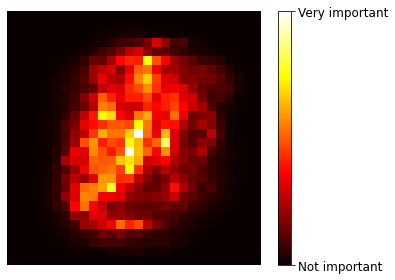

In [23]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# Boosting
Boosting (originally called hypothesis boosting) refers to any Ensemble method that
can combine several weak learners into a strong learner. The general idea of most
boosting methods is to train predictors sequentially, each trying to correct its prede‐
cessor

# AdaBoost
One way for a new predictor to correct its predecessor is to pay a bit more attention
to the training instances that the predecessor underfitted. This results in new predic‐
tors focusing more and more on the hard cases. This is the technique used by
AdaBoost

For example, when training an AdaBoost classifier, the algorithm first trains a base
classifier (such as a Decision Tree) and uses it to make predictions on the training set.
The algorithm then increases the relative weight of misclassified training instances.
Then it trains a second classifier, using the updated weights, and again makes predic‐
tions on the training set, updates the instance weights, and so on

There is one important drawback to this sequential learning techni‐
que: it cannot be parallelized (or only partially), since each predic‐
tor can only be trained after the previous predictor has been
trained and evaluated. As a result, it does not scale as well as bag‐
ging or pasting.

In [69]:
from IPython.display import HTML
video_path = "Chapter_7 _Ensemble\AdaBoost.mp4"

HTML("""
<video width="840" height="460" controls="">
<source src="{0}">
</video>
""".format(video_path))

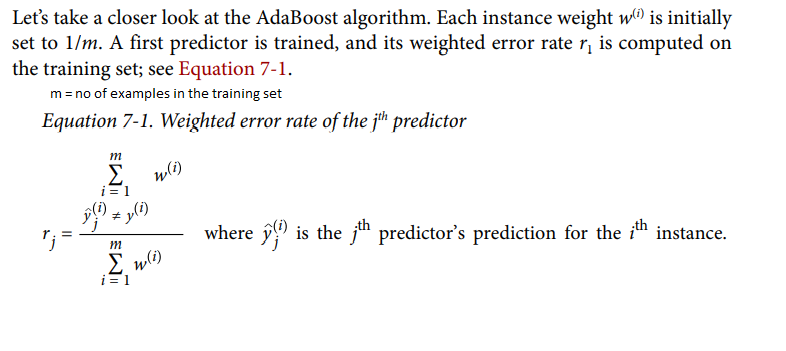

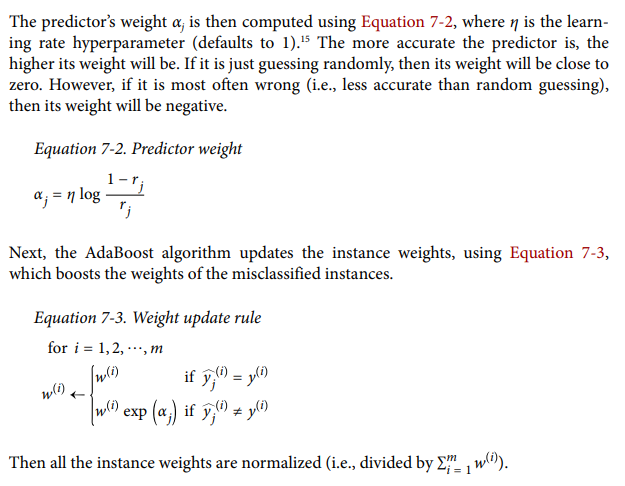

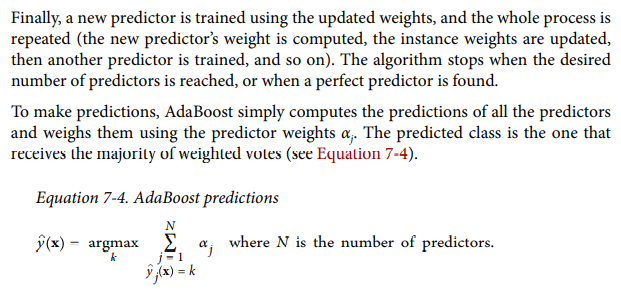

Scikit-Learn uses a multiclass version of AdaBoost called SAMME16 (which stands for
Stagewise Additive Modeling using a Multiclass Exponential loss function). When there
are just two classes, SAMME is equivalent to AdaBoost. If the predictors can estimate
class probabilities (i.e., if they have a predict_proba() method), Scikit-Learn can use
a variant of SAMME called SAMME.R (the R stands for “Real”), which relies on class
probabilities rather than predictions and generally performs better.


The following code trains an AdaBoost classifier based on 200 Decision Stumps using
Scikit-Learn’s AdaBoostClassifier class (as you might expect, there is also an Ada
BoostRegressor class). A Decision Stump is a Decision Tree with max_depth=1—in
other words, a tree composed of a single decision node plus two leaf nodes. This is
the default base estimator for the AdaBoostClassifier class:

In [38]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

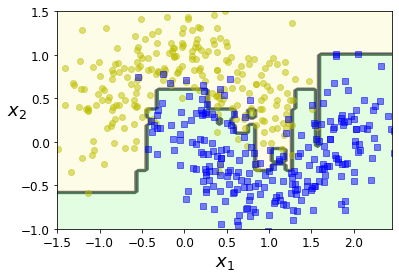

In [40]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    
plot_decision_boundary(ada_clf, X, y)

# Gradient Boosting


In [42]:
from IPython.display import HTML
video_path = "Chapter_7 _Ensemble\Gradient Boosting1.mp4"

HTML("""
<video width="840" height="460" controls="">
<source src="{0}">
</video>
""".format(video_path))

In [44]:
from IPython.display import HTML
video_path = "Chapter_7 _Ensemble\Gradient Boosting  Maths.mp4"

HTML("""
<video width="840" height="460" controls="">
<source src="{0}">
</video>
""".format(video_path))

First, let’s fit a DecisionTreeRegressor to the training set (for example, a noisy quadratic train‐
ing set)

In [45]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [46]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we’ll train a second DecisionTreeRegressor on the residual errors made by the
first predictor:

In [47]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:


In [48]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees:

In [49]:
X_new = np.array([[0.8]])

In [50]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [51]:
y_pred

array([0.75026781])

A simpler way to train Gradient Boosted Regression Trees (GBRT) ensembles is to use Scikit-Learn’s GradientBoostingRe
gressor class. Much like the RandomForestRegressor class, it has hyperparameters to
control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), as well as
hyperparameters to control the ensemble training, such as the number of trees
(n_estimators). The following code creates the same ensemble as the previous one:

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The learning_rate hyperparameter scales the contribution of each tree. If you set it
to a low value, such as 0.1, you will need more trees in the ensemble to fit the train‐
ing set, but the predictions will usually generalize better. This is a regularization tech‐
nique called shrinkage. 

In [53]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


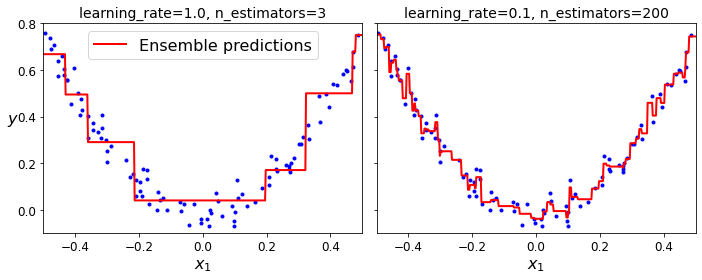

In [55]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

Figure 7-10 shows two GBRT ensembles trained with a low
learning rate: the one on the left does not have enough trees to fit the training set,
while the one on the right has too many trees and overfits the training set

# Gradient Boosting with Early stopping

In order to find the optimal number of trees, you can use early stopping (see Chap‐
ter 4). A simple way to implement this is to use the staged_predict() method: it
returns an iterator over the predictions made by the ensemble at each stage of train‐
ing (with one tree, two trees, etc.). The following code trains a GBRT ensemble with
120 trees, then measures the validation error at each stage of training to find the opti‐
mal number of trees, and finally trains another GBRT ensemble using the optimal
number of trees:

In [56]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [57]:
min_error = np.min(errors)

The validation errors are represented on the left of Figure 7-11, and the best model’s
predictions are represented on the right.


Saving figure early_stopping_gbrt_plot


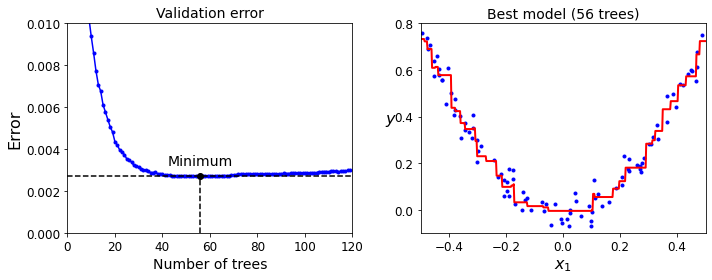

In [58]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early
(instead of training a large number of trees first and then looking back to find the
optimal number). You can do so by setting warm_start=True, which makes ScikitLearn keep existing trees when the fit() method is called, allowing incremental
training. The following code stops training when the validation error does not
improve for five iterations in a row:

In [59]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [60]:
print(gbrt.n_estimators)

61


In [61]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


The GradientBoostingRegressor class also supports a subsample hyperparameter,
which specifies the fraction of training instances to be used for training each tree. For
example, if subsample=0.25, then each tree is trained on 25% of the training instan‐
ces, selected randomly. As you can probably guess by now, this technique trades a
higher bias for a lower variance. It also speeds up training considerably. This is called
Stochastic Gradient Boosting

# Using XGBoost ( Extreme Gradient Boosting)
It is worth noting that an optimized implementation of Gradient Boosting is available
in the popular Python library XGBoost, which stands for Extreme Gradient Boosting.


In [64]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [65]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.004000408205406276


In [66]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.22834
[1]	validation_0-rmse:0.16224
[2]	validation_0-rmse:0.11843
[3]	validation_0-rmse:0.08760
[4]	validation_0-rmse:0.06848
[5]	validation_0-rmse:0.05709
[6]	validation_0-rmse:0.05297
[7]	validation_0-rmse:0.05129
[8]	validation_0-rmse:0.05155
[9]	validation_0-rmse:0.05211
Validation MSE: 0.002630868681577655


In [67]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

90.8 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [68]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

28.6 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Stacking
The last Ensemble method we will discuss in this chapter is called stacking (short for
stacked generalization).18 It is based on a simple idea: instead of using trivial functions
(such as hard voting) to aggregate the predictions of all predictors in an ensemble,
why don’t we train a model to perform this aggregation? Figure 7-12 shows such an
ensemble performing a regression task on a new instance. Each of the bottom three
predictors predicts a different value (3.1, 2.7, and 2.9), and then the final predictor
(called a blender, or a meta learner) takes these predictions as inputs and makes the
final prediction (3.0).

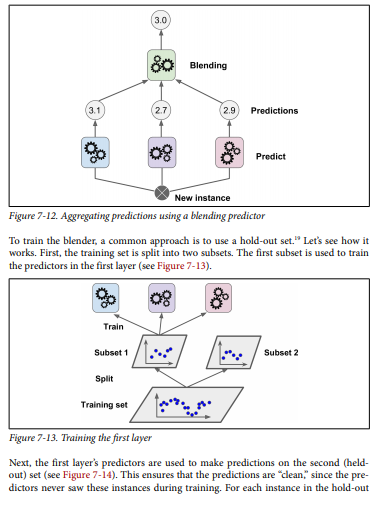

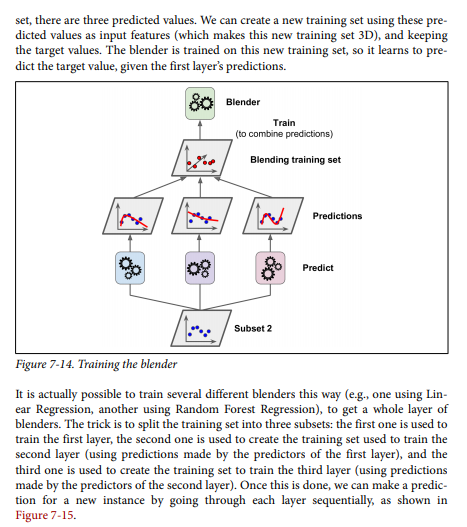

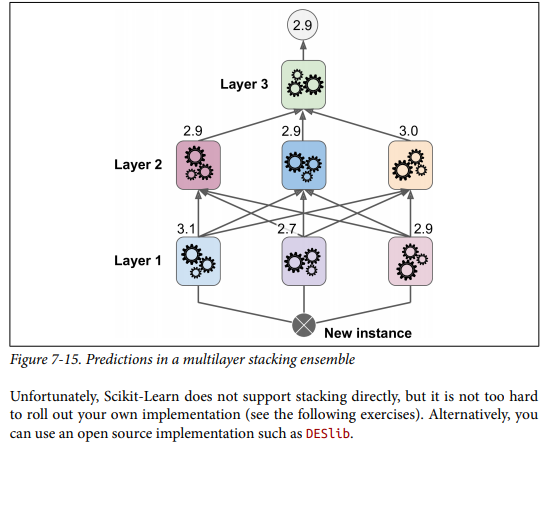